# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **18 de octubre** y se realizará a través de Bloque Neón.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [ ]:
data = pd.read_csv("creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("creditCardScore/credit_record.csv", encoding = 'utf-8')

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [ ]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Preparación de los Datos

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [ ]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [ ]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [ ]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [ ]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [ ]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [ ]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [ ]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [ ]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [ ]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [ ]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

In [ ]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Posesión de un Automóvil

In [ ]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Posesión de un Inmueble

In [ ]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Posesión de un Teléfono

In [ ]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

1    0.292791
0    0.707209
Name: phone, dtype: float64
El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Posesión de Correo Electrónico (Email)

In [ ]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Posesión de Teléfono para Trabajo

In [ ]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Descriptores Continuos

#### Cantidad de Hijos

In [ ]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [ ]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [ ]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0,0,0


#### Ingresos Anuales

Gráfica de Histograma para observar la distribución.

In [ ]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


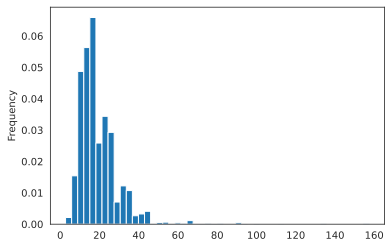

In [ ]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [ ]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

El IV de esta variable es: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


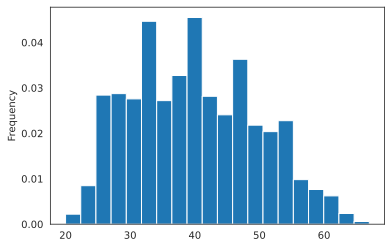

In [ ]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [ ]:
new_data = convert_dummy(new_data,'gp_Age')

#### Años de Trabajo

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

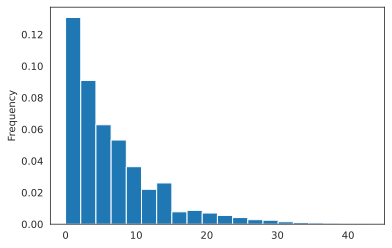

In [ ]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [ ]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [ ]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

State servant            2437
Working                 15622
Commercial associate     7052
Student                    10
Pensioner                  13
Name: inctp, dtype: int64
State servant           0.096960
Working                 0.621549
Commercial associate    0.280576
Student                 0.000398
Pensioner               0.000517
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [ ]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [ ]:
new_data = convert_dummy(new_data,'occyp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [ ]:
new_data = convert_dummy(new_data,'houtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [ ]:
new_data = convert_dummy(new_data,'edutp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Widow                   0.023076
Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Name: famtp, dtype: float64

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [ ]:
new_data = convert_dummy(new_data,'famtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [ ]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Separación de datos en conjuntos: entrenamiento y prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```


### A. Top 6

In [ ]:
X_train_subA = X_train[['gp_Age_high', 'gp_Age_highest', 'gp_Age_low','gp_Age_lowest',
                        'famtp_Civil marriage', 'famtp_Separated','famtp_Single / not married','famtp_Widow',
                        'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
                        'Reality',
                        'Gender',
                        'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_test_subA = X_test[['gp_Age_high', 'gp_Age_highest', 'gp_Age_low','gp_Age_lowest',
                        'famtp_Civil marriage', 'famtp_Separated','famtp_Single / not married','famtp_Widow',
                        'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
                        'Reality',
                        'Gender',
                        'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_train_subA.head()

,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,Reality,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
32515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.762931,1.0,0.0,0.0
14471,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
16400,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0
29956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.858506,1.0,1.000000,0.0,0.0,0.0
39904,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0


### B. Últimos 6

In [ ]:
X_train_subB = X_train[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment', 'houtp_Rented apartment', 'houtp_With parents', 
                        'famsizegp_1', 'famsizegp_3more',
                        'occyp_hightecwk', 'occyp_officewk',
                        'gp_inc_medium',  'gp_inc_high',
                        'wkphone',
                        'ChldNo_1', 'ChldNo_2More']]

X_test_subB = X_test[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment', 'houtp_Rented apartment', 'houtp_With parents', 
                        'famsizegp_1', 'famsizegp_3more',
                        'occyp_hightecwk', 'occyp_officewk',
                        'gp_inc_medium',  'gp_inc_high',
                        'wkphone',
                        'ChldNo_1', 'ChldNo_2More']]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0
14471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0
16400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0
29956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.000000,0.0,0.0,0.0
39904,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.477808,0.0,0.477808,0.0,0.0,0.0


## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

## Caso A

Precisión 0.59361
      0     1
0  3946  3468
1  2558  4856
[[3946 3468]
 [2558 4856]]


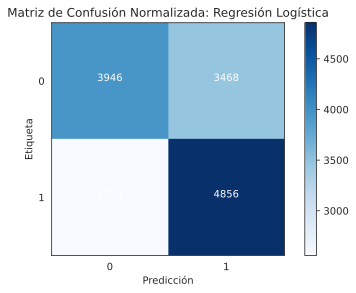

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

## Caso B

Precisión 0.53453
      0     1
0  3818  3596
1  3306  4108
[[3818 3596]
 [3306 4108]]


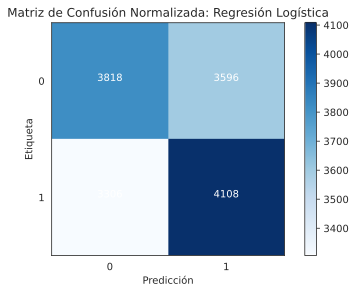

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB, y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Caso C

Precisión 0.59954
      0     1
0  4005  3409
1  2529  4885
[[4005 3409]
 [2529 4885]]


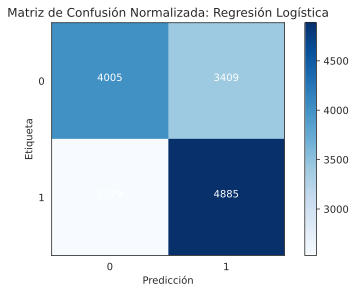

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística') 


## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.


### Caso A

Precisión 0.82668
      0     1
0  6429   985
1  1585  5829
[[6429  985]
 [1585 5829]]


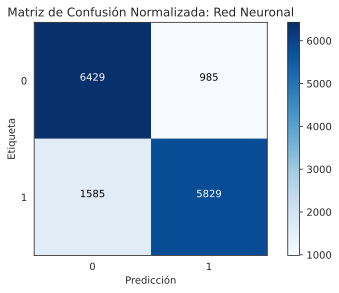

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20, 20), activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Precisión 0.76551
      0     1
0  5721  1693
1  1784  5630
[[5721 1693]
 [1784 5630]]


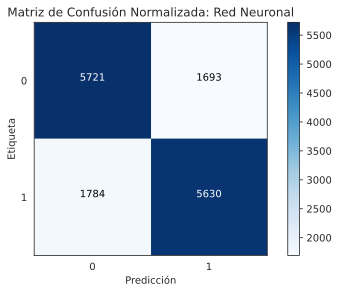

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20, 20), activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subB, y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Precisión 0.93849
      0     1
0  6869   545
1   367  7047
[[6869  545]
 [ 367 7047]]


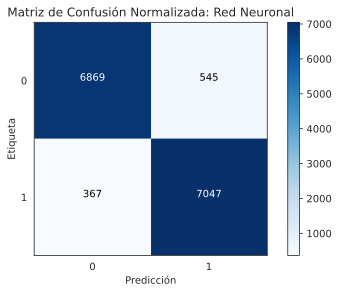

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20, 20), activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto Cmm #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Conclusiones Parte 2

En primer lugar, sobre la accesibilidad e implementación. Ambas funciones son parte de Sklearn, por lo que tener acceso a una de ellas implica tener acceso a la otra. Al usar los mismos datos de entrenamiento y validación se pudo evidenciar que hay una clara ventaja en el MLPClassifier. Su preseición supera siempre el 70%, e incluso en el caso C llega a 0.9385. En comparación con la regresión logistica presenta muchos menos casos de error tipo I y tipo 2. La regresión logistica como modelo en los 3 casos de prueba fue deficiente, con una precisión sobre el 0.5, lo cual significaba que tenía pocos más aciertos que errores. En un modelo de regresión lo que se busca es reducir este número y el modelo de MLPClassifier muestra un avance en esto.

En cuanto a la implementación práctica, por ejemplo, en un caso de no contar con el acceso a los recursos de Sklearn, se conoce como funciona una regresión logistica, y como se puede implementar desde cero. Pero la libreria de MLPClassifier no es conocida, y si usa un método de redes neuronal o una regresión logistica mejorada no es algo que nosotros podamos implementar. Pero en cuestión de recursos computacionales, no parece haber limitaciones en cuento a usar este ultimo modelamiento, por lo que es preferible en todo caso.

# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.



In [ ]:
# Dividir el conjunto de prueba (todos los descriptores) en las dos mitades solicitadas 
# (50% validación y 50% prueba)
X_Validacion_P3, X_Prueba_P3, Y_Validacion_P3, Y_Prueba_P3 = train_test_split(X_test, y_test, test_size=0.5)

### Caso A

In [ ]:
# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #

# Evaluación preliminar del modelo (Preguntar porque ni idea)

# Recorrido para conocer la precisión en los datos de validación dentro del escenario A
nNeuronas = [5, 10, 20, 50, 100]

# Accuracy array
preciCasoA = []

for j in range(len(nNeuronas)):
  modeloj_CasoA = MLPClassifier(hidden_layer_sizes=(nNeuronas[j]), activation='relu') 
  modeloj_CasoA.fit(X_Validacion_P3, Y_Validacion_P3)
  y_predict_CasoA = modeloj_CasoA.predict(X_Validacion_P3)
  print(f'Modelo 1 capa esondida con {nNeuronas[j]} neuronas:')
  # Almacenar la precisión de cada modelo
  preciCasoA.append(round(accuracy_score(Y_Validacion_P3, y_predict_CasoA),5))
  print(f'Precisión {round(accuracy_score(Y_Validacion_P3, y_predict_CasoA),5)}')
  print(pd.DataFrame(confusion_matrix(Y_Validacion_P3,y_predict_CasoA)))
  print('\n')


### Caso B

In [ ]:
# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #

# Evaluación preliminar del modelo (Preguntar porque ni idea)

# Recorrido para conocer la precisión en los datos de validación dentro del escenario B
nNeuronas = [5, 10, 20, 50, 100]

# Accuracy array
preciCasoB = []

for j in range(len(nNeuronas)):
  modeloj_CasoB = MLPClassifier(hidden_layer_sizes=(nNeuronas[j], nNeuronas[j]), activation='relu') 
  modeloj_CasoB.fit(X_Validacion_P3, Y_Validacion_P3)
  y_predict_CasoB = modeloj_CasoB.predict(X_Validacion_P3)
  print(f'Modelo 2 capas esondidas con {nNeuronas[j]} neuronas:')
  # Almacenar la precisión de cada modelo
  preciCasoB.append(round(accuracy_score(Y_Validacion_P3, y_predict_CasoB),5))
  print(f'Precisión {round(accuracy_score(Y_Validacion_P3, y_predict_CasoB),5)}')
  print(pd.DataFrame(confusion_matrix(Y_Validacion_P3,y_predict_CasoB)))
  print('\n')

### Caso C

In [ ]:
# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #

# Evaluación preliminar del modelo (Preguntar porque ni idea)

# Recorrido para conocer la precisión en los datos de validación dentro del escenario B
nNeuronas = [5, 10, 20, 50, 100]

# Accuracy array
preciCasoC = []

for j in range(len(nNeuronas)):
  modeloj_CasoC = MLPClassifier(hidden_layer_sizes=(nNeuronas[j], nNeuronas[j], nNeuronas[j]), activation='relu') 
  modeloj_CasoC.fit(X_Validacion_P3, Y_Validacion_P3)
  y_predict_CasoC = modeloj_CasoC.predict(X_Validacion_P3)
  print(f'Modelo 3 capas esondidas con {nNeuronas[j]} neuronas:')
  # Almacenar la precisión de cada modelo
  preciCasoC.append(round(accuracy_score(Y_Validacion_P3, y_predict_CasoC),5))
  print(f'Precisión {round(accuracy_score(Y_Validacion_P3, y_predict_CasoC),5)}')
  print(pd.DataFrame(confusion_matrix(Y_Validacion_P3,y_predict_CasoC)))
  print('\n')

### Gráficas Evaluativas

In [ ]:
# Graficar la precisión de los datos de validación para cada caso

# Caso A
plt.plot(nNeuronas, preciCasoA)
plt.title('Precisión con 1 capa escondida')
plt.xlabel('Número de Neuronas')
plt.ylabel('Precisión del Modelo')
plt.show()

# Caso B
plt.plot(nNeuronas, preciCasoB)
plt.title('Precisión con 2 capas escondidas')
plt.xlabel('Número de Neuronas')
plt.ylabel('Precisión del Modelo')
plt.show()

# Caso C
plt.plot(nNeuronas, preciCasoC)
plt.title('Precisión con 3 capas escondidas')
plt.xlabel('Número de Neuronas')
plt.ylabel('Precisión del Modelo')
plt.show()

## Conclusiones Parte 3

Para el escenario A (1 capa escondida) se encontró que el mejor modelo asociado únicamente a los datos de validación fue el que contaba con 100 neuronas, pues la precisión de este superaba al resto de valores calculados. 

En cuanto al escenario B (2 capas escondidas) el modelo que presentó una mayor precisión con los datos de validación fue el que contaba con 50 neuronas solamente. 

Por último, el escenario C (3 capas escondidas) logró una mayor precisión con un modelo de 100 neuronas, superando así la precisión del resto de modelos.

Es interesante ver cómo se ajusta cada una de las redes neuronales planteadas a los datos de validación (solamente) extraídos de los datos originales de prueba y en ninguno de los casos se llega a una precisión del 100%. Se esperaría que si se entrena una red a partir de un set de datos determinado y se utiliza el mismo grupo de datos para predecir unas etiquetas el error debería ser mínimo (sino es que es 0), pero la realidad experimental muestra que el alto número de factores/categorías que son contemplados permiten solamente dar un aproximado del mejor modelo que se ajusta al comportamiento de datos de entrenamiento. 

Estos tres modelos fueron evaluados con los sub-datos de prueba obtenidos del set original de datos de prueba y los resultados asociados se ven a continuación:

In [ ]:
print('Precisión de los mejores modelos por cada escenario: \n')

# Mejor modelo Escenario A
y_predict_CasoA = modeloj_CasoA.predict(X_Prueba_P3)
# Almacenar la precisión de cada modelo
print(f'Escenario A -> Precisión: {round(accuracy_score(Y_Prueba_P3, y_predict_CasoA),5)} \n')

# Mejor modelo Escenario B
y_predict_CasoB = modeloj_CasoB.predict(X_Prueba_P3)
# Almacenar la precisión de cada modelo
print(f'Escenario A -> Precisión: {round(accuracy_score(Y_Prueba_P3, y_predict_CasoB),5)} \n')

# Mejor modelo Escenario C
y_predict_CasoC = modeloj_CasoC.predict(X_Prueba_P3)
# Almacenar la precisión de cada modelo
print(f'Escenario A -> Precisión: {round(accuracy_score(Y_Prueba_P3, y_predict_CasoC),5)} \n')

# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # # # Implemente el método de backpropagation para la arquitectura seleccionada # # # #
# Requerimietos: Red neuronal (Capas, Pesos, vectores X(entrada) y Y(salida),Epsilon(Condicion de parada))
# 
# Ciclo por: 
# Foward y calculo delta-zero (Error, agregar ese a la presición)
# Backpropagation y actualización de W(pesos)
# Repetir hasta Error < Epsilon
#
# Condiciones especiales:
# Capas con igual número de neuronas (En cuyo caso, solo se tiene que especificar el # de capas, y el # de neuronas)
# Matriz de pesos iniciales (De no espeficar, se creará con valor de "1" en cada peso, y se operará como tal)
# Funcion de activación sigmoide, y función de salida lineal
# ...
def sig(x):
    return 1/(1 + np.exp(-x))
class MLP_Fnan:
    def BackPropagation(Entradas, Salidas, Capas, nNeuronas, tasa = 1/2, Pesos = 0, Eps = 1e-3):
        np.random.seed(0)
        # Caracterización de [número] de entradas y salidas
        if isinstance(Entradas, int):
          X = 1
        else:
          X = len(Entradas)
        if isinstance(Salidas, int):
          Y = 1
        else:
          Y = len(Salidas) 
        W = []
        if (Pesos == 0):

        # Creación de La matriz de pesos inicial W1, DEFAULT
            W.append(np.random.rand(nNeuronas,X)) 
        # Creación de las matrices de pesos por capas, DEFAULT
            for i in range(Capas-1):
                W.append(np.random.rand(nNeuronas,nNeuronas))
        # Creación de la matriz de pesos final Ws, DEFAULT
            W.append(np.random.rand(Y,nNeuronas))

        else:
            W = Pesos
        # Inicio del algoritmo
        Error = 1e100
        a = []
        a.append(Entradas)
        E = [] # Vector de los errores en cada iteración
        while np.linalg.norm(Error) > Eps: # Condición de parada
        # Iteración hacía adelante de la red: FORWARD
            # Ciclo por las capas de activación (# capas + capa final)
            for i in range(Capas+1):
                peso = W[i]
                z = sig(np.array(a[i]))                
                a.append(np.dot(peso,np.transpose(z)))
        # Cálculo del error
            h = a[-1]    
            Error = h - Salidas
            E.append(Error)
        # Iteración hacía atras
            # Ciclo por las capas hacía atrás: Cálculo de los deltas 
            d = []
            d.append(Error) # Matriz de los deltas, d_0 = Error
            for i in range(Capas, 0, -1):
                peso = W[i]
                z = sig(np.array(a[i]))
                # Derivada de la función sig (tamaño 1 x nNeuronas)
                k = 0
                for i in z:
                    z[k] = z[k]*(1-z[k]) # Notese que z(1-z) es la misma derivada de la función sigmoide
                    k+=1

                # Calculo de los deltas para la capa i (dj = zj(1-zj)*SUM(Wji*di))

                Sj = np.dot(d[-1],peso) # Vector de la suma de capa j(w_ji*d_i), tamaño de 1 x nNeuronas
                dj = np.multiply(Sj,z) # Multiplicación UNO A UNO
                d.append(dj)
            # Prepración de los deltas (Voltear el vector)
            d = d[::-1]
            # Actualización de los pesos
            for i in range(Capas+1):

                z = [sig(np.array(a[i]))]
                di = np.array([d[i]])
                L = np.dot(np.transpose(di),z) # Matriz de derivadas direccionales (o di*zi, en cada nodo)

                W[i] = W[i] - tasa*L
            
            a = []
            a.append(Entradas)
        # Grafica de la evoluación del error (Prescision de la red)    
        iteraciones = []    
        for i in range(0,len(E)):
            iteraciones.append(i)
        plt.plot(iteraciones, E)
        plt.title('Disminución del error lineal')
        plt.xlabel('Número de iteración')
        plt.ylabel('Error del Modelo')
        plt.show()
        #Regresa el modelo (La matriz de pesos para esta red neuronal)
        return W
    # Funcion unicamente para probar una matriz de pesos en una entrada (Es solo un ciclo hacia adelante)
    def Forward(Entradas, Pesos):
        # Ciclo por las capas de activación (# capas + capa final)
        Capas = len(Pesos)-1
        W = Pesos
        b = []
        b.append(Entradas)
        for i in range(Capas+1):
          peso = W[i]
          z = sig(np.array(b[i]))
          b.append(np.dot(peso,np.transpose(z)))
        # Cálculo de la salida (Evaluación del modelo)
        h = b[-1]
        return h




Capas: 4
Entradas: 2
Salidas: 1


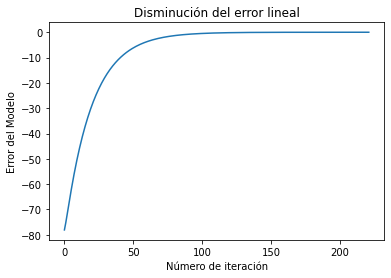

Capas: 4
Entradas: 2
Salidas: 1


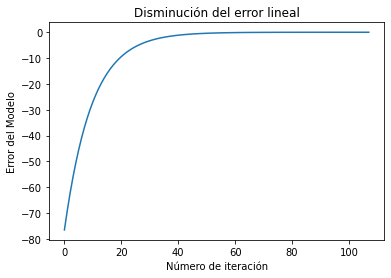

Capas: 4
Entradas: 2
Salidas: 1


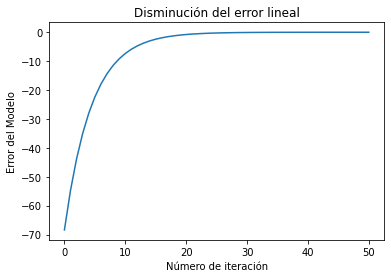

Capas: 4
Entradas: 2
Salidas: 1


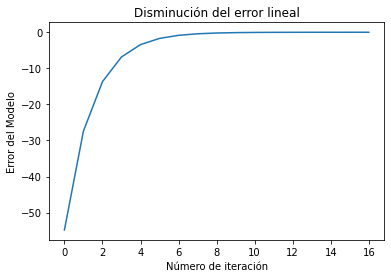

Capas: 4
Entradas: 2
Salidas: 1


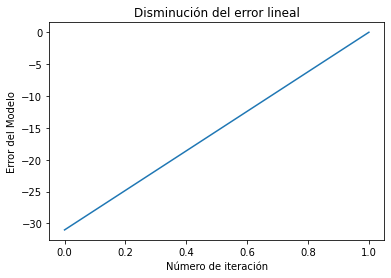

In [ ]:
# Pruebas con diferentes neuronas, en 4 capas.
nNeuronas = [5, 10, 20, 50, 100]
tasas = []
model = MLP_Fnan
for i in nNeuronas:
    model.BackPropagation([-50,78],80,4,i,0.01)


Al operar con diferente cantidad de neuronas, en un mismo número de capas se pudo observar como la red es más sencible al cambio. Por ejemplo, al mantener una tasa constante se puede observar como la red neuronal converge en menos iteraciones, incluso haciendolo en 1 iteración (por coincidencia del % de error). Además, al cambiar esta tasa, por ejemplo en 0.5 para 5 neuronas el número de iteraciones disminuye, pero al aumentar las neuronas con esta misma tasa entonces la red diverge. Por lo que la tasa más adecuada es inversamente proporcional al número de neuronas. Por otro lado el código ejecutado es bastante eficiente con los parámetros correctos. Por lo que si el sistema no da ninguna solución es porque simplemente divergió, o se quedó oscilando entre dos valores debido a la tasa incorrecta. Estos resultados solo se obtuvieron de forma experimental, en caso de llegar a obtenerlos se debe detener el código y cambiar la tasa.

Finalmente, reflexionamos en poder encontrar la tasa adecuada y es que esta siempre estará directamente asociada a la matriz de pesos W, que está actualizando. ¿Y si existiera una fórmula que variara la tasa con el tiempo? Según el error, el % de error, el número de neuronas y el número de capas. Por ahora, nos limitamos a escribir y probar el algoritmo de Backpropagation para la actualización de pesos random (con semilla 0) de una red neuronal.

Capas: 3
Entradas: 3
Salidas: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


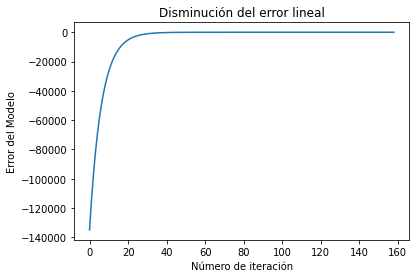

Capas: 3
Entradas: 3
Salidas: 1


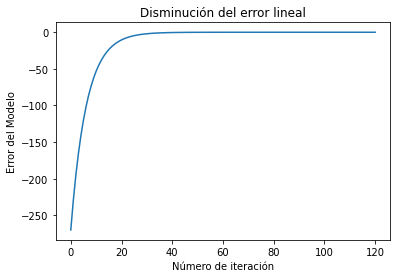

Capas: 3
Entradas: 3
Salidas: 1


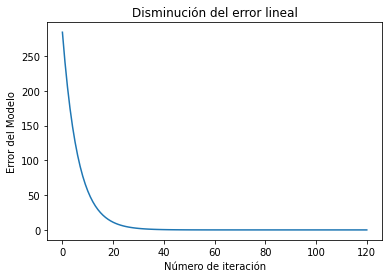

Capas: 3
Entradas: 3
Salidas: 1


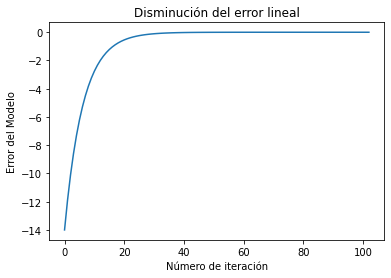

Capas: 3
Entradas: 3
Salidas: 1


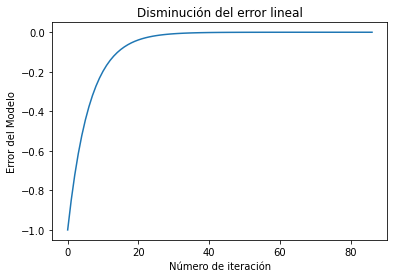

[0.99999928]


In [ ]:
# Más testeos sobre el modelo
modelBack = model.BackPropagation([5,0,0],0,3,10,0.05,modelBack,Eps = 1e-6)
modelBack = model.BackPropagation([5,6,9],270,3,10,0.05,modelBack,Eps = 1e-6)
modelBack = model.BackPropagation([1,-7,2],-14,3,10,0.05,modelBack,Eps = 1e-6)
modelBack = model.BackPropagation([5,0,0],0,3,10,0.05,modelBack,Eps = 1e-6)
modelBack = model.BackPropagation([1,1,1],1,3,10,0.05,modelBack,Eps = 1e-6)